In [5]:
import csv
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

from collections import Counter
from sentence_transformers import SentenceTransformer, util
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tqdm.notebook import tqdm

In [6]:
model = SentenceTransformer('sentence-transformers/multi-qa-mpnet-base-cos-v1')

In [7]:
# Data link: https://www.kaggle.com/datasets/karnikakapoor/video-ads-engagement-dataset?resource=download
campaign_ctr = Counter()
data_dir = "../data/Advertising"
with open(os.path.join(data_dir, "ad_df.csv")) as f:
    reader = csv.DictReader(f)
    for r in reader:
        campaign_ctr[r['campaign_id']] += 1

In [8]:
top_campaigns = {x[0] for x in sorted(campaign_ctr.items(), key=lambda x: -1*x[1])[:100]}

In [9]:
top_campaigns

{'124391',
 '184750',
 '191254',
 '197246',
 '197257',
 '197349',
 '197912',
 '198951',
 '205843',
 '208037',
 '208435',
 '208469',
 '208878',
 '209150',
 '210361',
 '210362',
 '210633',
 '210635',
 '210685',
 '210702',
 '210802',
 '211167',
 '211305',
 '211331',
 '211332',
 '211499',
 '211516',
 '211518',
 '211520',
 '211521',
 '211522',
 '211733',
 '211831',
 '211853',
 '211950',
 '211998',
 '212176',
 '212229',
 '212246',
 '212923',
 '212971',
 '213012',
 '213131',
 '213287',
 '213314',
 '213315',
 '213336',
 '213351',
 '213370',
 '213453',
 '213454',
 '213708',
 '213745',
 '213746',
 '213783',
 '213877',
 '213879',
 '213912',
 '213956',
 '214002',
 '214003',
 '214126',
 '214175',
 '214320',
 '214323',
 '214397',
 '214483',
 '214490',
 '214515',
 '214520',
 '214593',
 '214626',
 '214627',
 '214630',
 '214631',
 '214633',
 '214647',
 '214693',
 '214698',
 '214774',
 '214871',
 '214873',
 '214875',
 '214879',
 '214881',
 '214883',
 '214937',
 '215116',
 '215197',
 '215250',
 '215393',

In [10]:
full_dset = []

In [11]:
rand_prob = .005
gen = np.random.default_rng(seed=0)

In [13]:
with open(os.path.join(data_dir, "ad_df.csv")) as f:
    reader = csv.DictReader(f)
    for r in reader:
        if r['campaign_id'] in top_campaigns and len(r['referer_deep_three']) and gen.random() < rand_prob:
            full_dset.append([r['campaign_id'], r['advertiser_id'], 
                              r['creative_duration'], r['placement_language'],
                              r['referer_deep_three'], r['ua_country'], r['ua_os'], 
                              r['ua_browser'], r['user_average_seconds_played'], r['seconds_played']])

In [14]:
len(full_dset)

10493

In [10]:
# Break out the campaign id, placement_language, ua_country, ua_os, and ua_browser into one-hot encodings, 
# and also get embeddings for the referer_deep_three feature

# Maybe actually encode both the 2nd and 3rd levels
# vocab = set()
# for x in tqdm(full_dset):
#     lvls = x[4].split("/")
#     lvls += [""]*(3-len(lvls))
#     vocab |= {lvls[-2].strip(), lvls[-1].strip()}
# len(vocab)    

In [11]:
# sorted_vocab = sorted(list(vocab))

In [12]:
# len(sorted_vocab)
# pickle.dump(sorted_vocab, open("data/Advertising/sorted_vocab.pkl", 'wb'))

In [13]:
# vocab_embs = []
# chunk = 100
# for idx in tqdm(range(len(vocab)//chunk + 1)):
#     vocab_embs.extend(model.encode(sorted_vocab[idx:min(len(sorted_vocab), idx+chunk)]))

In [15]:
fname = os.path.join(data_dir, "vocab_embs.pkl")
# pickle.dump(vocab_embs, open("data/Advertising/vocab_embs.pkl", 'wb'))
vocab_embs = pickle.load(open(fname, 'rb'))
fname = os.path.join(data_dir, "sorted_vocab.pkl")
sorted_vocab = pickle.load(open(fname, 'rb'))

In [16]:
vocab_embs[0].shape

(768,)

In [17]:
df = pd.DataFrame(full_dset)

In [18]:
df.columns = ['campaign_id','advertiser_id', 'creative_duration', 'placement_language', 
              'referer_deep_three', 'ua_country', 'ua_os', 'ua_browser', 'user_average_seconds_played', 'seconds_played']

In [19]:
df_dummies = pd.get_dummies(df, columns=['campaign_id','placement_language', 'ua_country', 'ua_os', 'ua_browser'])

In [20]:
embs = np.zeros((len(full_dset), 768*2))
for idx, x in tqdm(enumerate(full_dset)):
    lvls = x[4].split("/")
    lvls += [""]*(3-len(lvls))
    embs[idx, :768] = vocab_embs[sorted_vocab.index(lvls[-2].strip())]
    embs[idx, 768:] = vocab_embs[sorted_vocab.index(lvls[-1].strip())]

0it [00:00, ?it/s]

In [21]:
df_dummies = df_dummies.drop(columns=['referer_deep_three', 'advertiser_id'])

In [22]:
list(df_dummies.columns)

['creative_duration',
 'user_average_seconds_played',
 'seconds_played',
 'campaign_id_124391',
 'campaign_id_184750',
 'campaign_id_191254',
 'campaign_id_197246',
 'campaign_id_197257',
 'campaign_id_197349',
 'campaign_id_197912',
 'campaign_id_198951',
 'campaign_id_205843',
 'campaign_id_208037',
 'campaign_id_208435',
 'campaign_id_208469',
 'campaign_id_208878',
 'campaign_id_209150',
 'campaign_id_210361',
 'campaign_id_210362',
 'campaign_id_210633',
 'campaign_id_210635',
 'campaign_id_210685',
 'campaign_id_210702',
 'campaign_id_210802',
 'campaign_id_211167',
 'campaign_id_211305',
 'campaign_id_211331',
 'campaign_id_211332',
 'campaign_id_211499',
 'campaign_id_211516',
 'campaign_id_211518',
 'campaign_id_211520',
 'campaign_id_211521',
 'campaign_id_211522',
 'campaign_id_211733',
 'campaign_id_211831',
 'campaign_id_211853',
 'campaign_id_211950',
 'campaign_id_211998',
 'campaign_id_212176',
 'campaign_id_212229',
 'campaign_id_212246',
 'campaign_id_212923',
 'campa

In [23]:
embs = pd.DataFrame(embs)

In [24]:
embs[:10]

,0,1,2,3,4,5,6,7,8,9,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,0.027784,0.047202,-0.010876,0.095864,-0.014336,0.028297,-0.051273,0.032479,0.068720,0.031993,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
1,-0.020265,-0.032737,-0.027273,0.085705,-0.034904,0.027943,-0.032076,-0.023835,0.027494,-0.010151,...,-0.039331,-0.034330,-0.024178,-0.011741,-0.016793,0.090289,-0.007154,0.014096,-0.039638,-0.041874
2,-0.005945,0.005390,-0.006077,0.071529,0.025388,-0.012745,0.048069,-0.020013,0.052446,0.010897,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
3,0.012271,0.008988,-0.009352,0.085603,-0.030366,0.027193,-0.046770,0.001877,0.009155,-0.008132,...,0.000713,-0.038265,0.004608,-0.009435,-0.034728,-0.006347,-0.001462,0.024552,0.013414,-0.042175
4,0.016959,-0.019917,-0.007092,0.111284,-0.041047,0.000312,-0.013700,-0.009160,0.044137,-0.013007,...,-0.065439,-0.016411,-0.016732,-0.007972,-0.019951,-0.017936,0.010354,-0.034208,-0.022828,-0.063246
5,0.043788,0.053650,0.014296,0.067872,-0.046509,-0.009361,-0.002462,0.015553,0.033761,-0.027542,...,-0.016822,-0.023132,-0.021015,-0.005174,-0.000301,0.061557,0.009487,0.014414,-0.000384,-0.056447
6,0.056821,0.019794,0.003355,0.045874,-0.058656,-0.012505,-0.010499,0.023427,0.064167,-0.002275,...,-0.042933,-0.056517,0.006019,-0.005139,-0.018081,0.022688,0.001619,0.014257,0.015371,-0.066681
7,0.016614,0.033328,-0.000899,0.112945,-0.028835,-0.013752,-0.011304,0.028817,0.041688,-0.023697,...,-0.016822,-0.023132,-0.021015,-0.005174,-0.000301,0.061557,0.009487,0.014414,-0.000384,-0.056447
8,0.007257,0.025274,-0.008864,0.104797,-0.010280,-0.016624,0.020302,-0.016626,0.041220,0.004362,...,-0.031861,-0.036831,-0.053912,-0.053342,-0.038274,-0.004708,-0.029724,-0.005160,0.014245,-0.077273
9,0.010871,-0.000312,-0.029308,0.123859,-0.006104,0.035437,-0.004928,0.038769,0.018683,0.015656,...,-0.044657,-0.028073,0.004691,0.014291,-0.033981,-0.041071,0.014619,0.029805,0.068564,-0.022144


In [25]:
joined = df_dummies.join(embs)

In [26]:
y = joined['seconds_played']

In [27]:
joined[joined['user_average_seconds_played'] == ''] = 0.0

In [28]:
np.any(joined['user_average_seconds_played'] == '')

False

In [29]:
all_x_cols = joined.columns.tolist()
all_x_cols.remove("seconds_played")

In [30]:
random_idxs = sorted(range(joined.shape[0]), key=lambda x: gen.random())

In [31]:
train_cutoff = int(.8*len(random_idxs))
train_idxs = random_idxs[:train_cutoff]
test_idxs = random_idxs[train_cutoff:]

In [32]:
joined

,creative_duration,user_average_seconds_played,seconds_played,campaign_id_124391,campaign_id_184750,campaign_id_191254,campaign_id_197246,campaign_id_197257,campaign_id_197349,campaign_id_197912,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
0,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,30,19.200000762939453,30,0,0,0,0,0,0,0,...,-0.039331,-0.03433,-0.024178,-0.011741,-0.016793,0.090289,-0.007154,0.014096,-0.039638,-0.041874
2,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10488,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10489,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10490,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10491,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [33]:
kernel = DotProduct()
gp = GaussianProcessRegressor(kernel=kernel, alpha=.1)

gp.fit(joined[all_x_cols].iloc[train_idxs], y.iloc[train_idxs])

C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\gaussian_process\kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter sigma_0 is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=0.1, kernel=DotProduct(sigma_0=1))

In [ ]:
# Pick out like 80% as train and 20% as test? 
# Either way, we need to drop the advertiser id and convert referer_deep_three to the embeddings.
# I'm a bit worried that this will be too big to run on the laptop, so probably debug with a smaller set and then
# run the larger training on Swarm or something.


In [34]:
mean_prediction, std_prediction = gp.predict(joined[all_x_cols].iloc[test_idxs], return_std=True)

C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [35]:
mean_prediction

array([5.31103310e+00, 8.89951988e+00, 7.22433639e+00, ...,
       4.72967634e-11, 4.72967634e-11, 4.72967634e-11])

In [36]:
std_prediction

array([6.13738286e-02, 8.75631956e-02, 8.42670396e-02, ...,
       9.99997293e-06, 9.99997293e-06, 9.99997293e-06])

In [37]:
y.iloc[test_idxs]

10053      9
7910       6
4258      21
3887     0.0
6953       3
        ... 
1789     0.0
6759     0.0
1057     0.0
7487     0.0
5262     0.0
Name: seconds_played, Length: 2099, dtype: object

In [38]:
# Cross the test users with the campaigns and predict the mean and standard deviation for how long they'll watch
# Create a numpy array that holds the means, and one that holds the std devs

mus = np.zeros((len(top_campaigns), len(test_idxs)))
sigs = np.zeros((len(top_campaigns), len(test_idxs)))
print(mus.shape)

(100, 2099)


In [39]:
test_joined = joined.iloc[test_idxs]

In [40]:
test_joined

,creative_duration,user_average_seconds_played,seconds_played,campaign_id_124391,campaign_id_184750,campaign_id_191254,campaign_id_197246,campaign_id_197257,campaign_id_197349,campaign_id_197912,...,1526,1527,1528,1529,1530,1531,1532,1533,1534,1535
10053,14,16.0,9,0,0,0,0,0,0,0,...,0.021388,-0.014516,0.045246,0.004600,-0.027450,-0.054890,0.009458,-0.010986,-0.030796,-0.021520
7910,29,0.5,6,0,0,0,0,0,0,0,...,-0.021775,-0.021787,-0.053087,-0.011330,-0.038255,0.006409,-0.007425,0.022089,-0.011062,-0.034186
4258,29,12.333333015441896,21,0,0,0,0,0,0,0,...,-0.054370,-0.033921,0.002015,0.002292,-0.011353,-0.022854,0.005557,0.009204,0.001424,-0.055541
3887,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6953,14,1.0,3,0,0,0,0,0,0,0,...,-0.015757,-0.005016,-0.046605,-0.006888,-0.013300,0.055089,0.009686,-0.063250,-0.011875,-0.069677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1789,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6759,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1057,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7487,0.0,0.0,0.0,0,0,0,0,0,0,0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [41]:
for idx, campaign in tqdm(enumerate(top_campaigns)):
    # Replace all campaigns in the test dataframe with this campaign, and predict the rows of the mean and std matrices
    for cid in top_campaigns:
        test_joined['campaign_id_%s' % cid] = 0
    test_joined['campaign_id_%s' % campaign] = 1
    mean_prediction, std_prediction = gp.predict(test_joined[all_x_cols], return_std=True)
    mus[idx] = mean_prediction
    sigs[idx] = std_prediction

0it [00:00, ?it/s]

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % cid] = 0
C:\Users\Justin Payan\AppData\Local\Temp\ipykernel_26120\3406993011.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_joined['campaign_id_%s' % campaign] = 1
C:\Users\Justin Payan\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['

In [42]:
np.save(os.path.join(data_dir, "mus.npy"), mus)
np.save(os.path.join(data_dir, "sigs.npy"), sigs)

<Axes: ylabel='Count'>

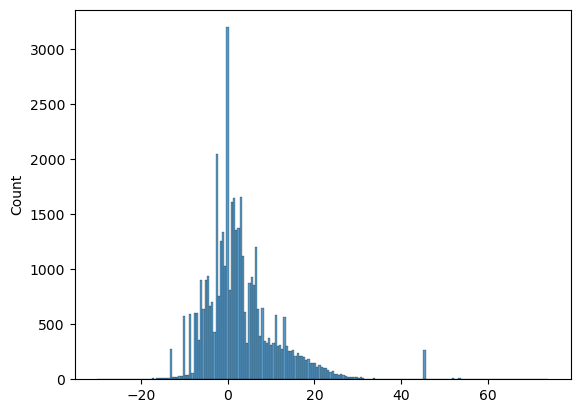

In [91]:
sns.histplot(mus.flatten())

<Axes: ylabel='Count'>

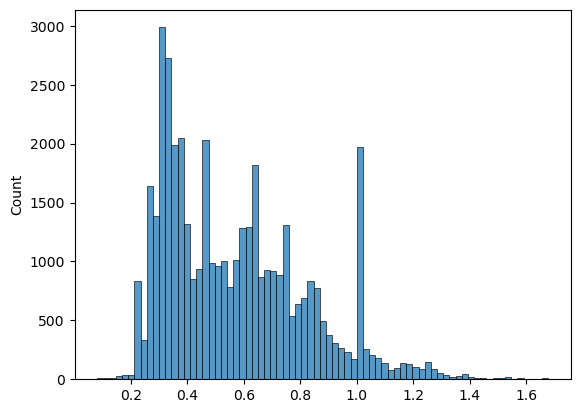

In [92]:
sns.histplot(sigs.flatten())